<a href="https://colab.research.google.com/github/FreMeli/Machine/blob/main/P1_GESTION_DEL_RIESGO_FREYA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Cargar librerías y datos

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score
from scipy.stats import ks_2samp
from sklearn.preprocessing import MinMaxScaler

# Configuración de visualización actualizada
plt.style.use('seaborn-v0_8')  # o alguno de los otros estilos mencionados
plt.rcParams['figure.figsize'] = [12, 8]
sns.set_palette("husl")
pd.options.display.float_format = '{:.4f}'.format


In [106]:

# ======================
# PASO 2: Carga y división de datos
# ======================
df = pd.read_excel('Proyecto 1 Datos.xlsm', sheet_name='E3')
df.head()

,User_ID,Gender,Age,EstimatedSalary_USD,Purchased,Sample
0,15624510,Male,19,19000,0,Train
1,15810944,Male,35,20000,0,Train
2,15668575,Female,26,43000,0,Train
3,15603246,Female,27,57000,0,Train
4,15804002,Male,19,76000,0,Train


In [107]:
# Separar en train y test
df_train = df[df['Sample'] == 'Train']
df_test = df[df['Sample'] == 'Test']

#Estadística Descriptiva

In [108]:
# Estadísticas descriptivas para variables numéricas
print("🔹 Estadística descriptiva - TRAIN")
print(df_train.describe())

print("\n🔹 Estadística descriptiva - TEST")
print(df_test.describe())

print("\n🔹 Estadística descriptiva - TOTAL")
print(df.describe())

🔹 Estadística descriptiva - TRAIN
            User_ID      Age  EstimatedSalary_USD  Purchased
count      299.0000 299.0000             299.0000   299.0000
mean  15689344.6722  37.7224           70558.5284     0.3679
std      71664.7126  10.3450           33034.7451     0.4830
min   15566689.0000  18.0000           15000.0000     0.0000
25%   15621627.0000  30.0000           47000.0000     0.0000
50%   15689425.0000  37.0000           71000.0000     0.0000
75%   15749858.0000  46.0000           88000.0000     1.0000
max   15814553.0000  60.0000          149000.0000     1.0000

🔹 Estadística descriptiva - TEST
            User_ID      Age  EstimatedSalary_USD  Purchased
count      101.0000 101.0000             101.0000   101.0000
mean  15698038.0792  37.4554           67326.7327     0.3267
std      71599.4210  10.9312           37132.7642     0.4714
min   15569641.0000  19.0000           15000.0000     0.0000
25%   15642885.0000  28.0000           35000.0000     0.0000
50%   15701962.00

#Agrupar Edad y Salario

In [109]:
# Definir rangos de edad
bins_age = [0, 30, 45, 60, 100]
labels_age = ['1', '2', '3', '60+']
#<=30 :1
#31-45 : 2
# 46-60 : 3

df['Age_bin'] = pd.cut(df['Age'], bins=bins_age, labels=labels_age)
df.head()


,User_ID,Gender,Age,EstimatedSalary_USD,Purchased,Sample,Age_bin
0,15624510,Male,19,19000,0,Train,1
1,15810944,Male,35,20000,0,Train,2
2,15668575,Female,26,43000,0,Train,1
3,15603246,Female,27,57000,0,Train,1
4,15804002,Male,19,76000,0,Train,1


In [110]:
# Definir tramos manuales de salario
bins_salary = [0, 30000, 60000, 90000, 120000, 150000, 200000]
labels_salary = ['1', '2', '3', '4', '5', '150k+']
#0-3 k :1
#30-60 :2
#60-90: 3
#90-120 :4
#120-150: 5
df['Salary_bin_fixed'] = pd.cut(df['EstimatedSalary_USD'], bins=bins_salary, labels=labels_salary)

df.head()

,User_ID,Gender,Age,EstimatedSalary_USD,Purchased,Sample,Age_bin,Salary_bin_fixed
0,15624510,Male,19,19000,0,Train,1,1
1,15810944,Male,35,20000,0,Train,2,1
2,15668575,Female,26,43000,0,Train,1,2
3,15603246,Female,27,57000,0,Train,1,2
4,15804002,Male,19,76000,0,Train,1,3


In [111]:
print(df['Age_bin'].value_counts(sort=False))

Age_bin
1      111
2      186
3      103
60+      0
Name: count, dtype: int64


In [112]:
print(df['Salary_bin_fixed'].value_counts(sort=False))

Salary_bin_fixed
1         57
2        117
3        143
4         42
5         41
150k+      0
Name: count, dtype: int64


#Calcular el WoE

In [113]:
import numpy as np
import pandas as pd

def calcular_woe(df, feature, target):
    # Total de eventos (compradores) y no eventos (no compradores)
    total_events = df[target].sum()
    total_non_events = len(df) - total_events

    # Agrupar por la variable y contar eventos y no eventos
    grouped = df.groupby(feature)[target].agg(['count', 'sum']).rename(columns={'sum': 'event'})
    grouped['non_event'] = grouped['count'] - grouped['event']

    # Calcular las proporciones
    grouped['fdp_buenos'] = grouped['event'] / total_events
    grouped['fdp_malos'] = grouped['non_event'] / total_non_events

    # Calcular el WoE
    grouped['woe'] = np.log(grouped['fdp_buenos'] / grouped['fdp_malos'])

    return grouped[['event', 'non_event', 'fdp_buenos', 'fdp_malos', 'woe']]


In [114]:
woe_age = calcular_woe(df, 'Age_bin', 'Purchased')
df['Age_WoE'] = df['Age_bin'].map(woe_age['woe'].to_dict())

woe_salary = calcular_woe(df, 'Salary_bin_fixed', 'Purchased')
df['Salary_WoE'] = df['Salary_bin_fixed'].map(woe_salary['woe'].to_dict())

woe_gender = calcular_woe(df, 'Gender', 'Purchased')
df['Gender_WoE'] = df['Gender'].map(woe_gender['woe'].to_dict())

df.head()

/tmp/ipython-input-113-2985477606.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(feature)[target].agg(['count', 'sum']).rename(columns={'sum': 'event'})
/tmp/ipython-input-113-2985477606.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(feature)[target].agg(['count', 'sum']).rename(columns={'sum': 'event'})


,User_ID,Gender,Age,EstimatedSalary_USD,Purchased,Sample,Age_bin,Salary_bin_fixed,Age_WoE,Salary_WoE,Gender_WoE
0,15624510,Male,19,19000,0,Train,1,1,-2.2760,-0.0290,-0.0916
1,15810944,Male,35,20000,0,Train,2,1,-0.4419,-0.0290,-0.0916
2,15668575,Female,26,43000,0,Train,1,2,-2.2760,-0.6177,0.0858
3,15603246,Female,27,57000,0,Train,1,2,-2.2760,-0.6177,0.0858
4,15804002,Male,19,76000,0,Train,1,3,-2.2760,-0.9656,-0.0916


In [115]:
df[['Age', 'Age_bin', 'Age_WoE', 'EstimatedSalary_USD', 'Salary_bin_fixed', 'Salary_WoE', 'Gender', 'Gender_WoE']].head()


,Age,Age_bin,Age_WoE,EstimatedSalary_USD,Salary_bin_fixed,Salary_WoE,Gender,Gender_WoE
0,19,1,-2.2760,19000,1,-0.0290,Male,-0.0916
1,35,2,-0.4419,20000,1,-0.0290,Male,-0.0916
2,26,1,-2.2760,43000,2,-0.6177,Female,0.0858
3,27,1,-2.2760,57000,2,-0.6177,Female,0.0858
4,19,1,-2.2760,76000,3,-0.9656,Male,-0.0916


#Regresión Logística

##MODELO 1

In [88]:
import statsmodels.api as sm
import pandas as pd

# Cargar datos y separar Train/Test
df_train = df[df["Sample"] == "Train"]

# Variables predictoras y target
X_train = df_train[["Gender_WoE", "Salary_WoE", "Age_WoE"]]
y_train = df_train["Purchased"]

# Agregar constante (intercepto) como en R
X_train_sm = sm.add_constant(X_train)

# Entrenar modelo logit
model_sm = sm.Logit(y_train, X_train_sm)
result = model_sm.fit()

# Mostrar resumen detallado
print(result.summary2())


Optimization terminated successfully.
         Current function value: 0.324180
         Iterations 7
                         Results: Logit
Model:              Logit            Method:           MLE       
Dependent Variable: Purchased        Pseudo R-squared: 0.507     
Date:               2025-06-22 03:58 AIC:              201.8593  
No. Observations:   299              BIC:              216.6611  
Df Model:           3                Log-Likelihood:   -96.930   
Df Residuals:       295              LL-Null:          -196.69   
Converged:          1.0000           LLR p-value:      5.3568e-43
No. Iterations:     7.0000           Scale:            1.0000    
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
const         -0.6111    0.1882  -3.2478  0.0012  -0.9799  -0.2423
Gender_WoE    -2.9598    2.1324  -1.3880  0.1651  -7.1393   1.

Interpretación:

Salary_WoE y Age_WoE son significativas (p < 0.001).

Gender_WoE no es significativa (p = 0.165).

El modelo tiene un Pseudo R² de 0.5072, lo que indica una buena capacidad explicativa.



Matriz de correlación:
            Gender_WoE  Salary_WoE  Age_WoE
Gender_WoE      1.0000      0.0780   0.1252
Salary_WoE      0.0780      1.0000   0.2265
Age_WoE         0.1252      0.2265   1.0000


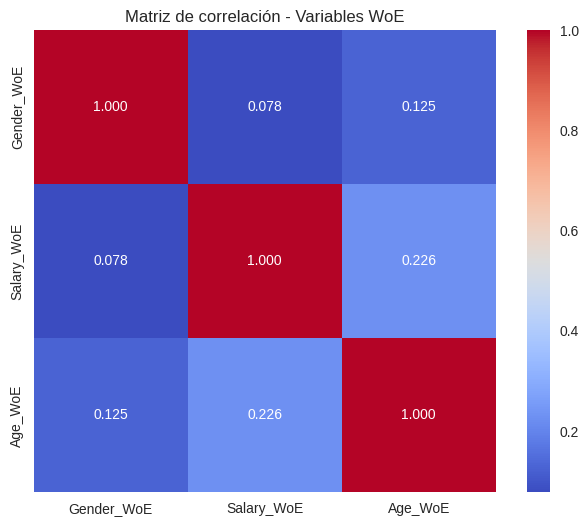

In [116]:
# Crear un DataFrame con las variables WoE del set de entrenamiento
woe_vars = df[df["Sample"] == "Train"][["Gender_WoE", "Salary_WoE", "Age_WoE"]]

# Calcular la matriz de correlación
correlation_matrix = woe_vars.corr()

# Mostrar la matriz de correlación
print("Matriz de correlación:")
print(correlation_matrix)

# Graficar mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".3f", square=True)
plt.title("Matriz de correlación - Variables WoE")
plt.show()

Gender y Salary estan muy relacionadas

##MODELO 2: SIN GENDER


In [117]:
# Separar Train
df_train = df[df["Sample"] == "Train"]
y_train = df_train["Purchased"]

# -------- Modelo A: sin Gender_WoE --------
X_train_A = df_train[["Salary_WoE", "Age_WoE"]]
X_train_A = sm.add_constant(X_train_A)  # Agregar constante (intercepto)
model_A = sm.Logit(y_train, X_train_A)
result_A = model_A.fit()
print("=== RESUMEN MODELO A (sin Gender_WoE) ===")
print(result_A.summary())

Optimization terminated successfully.
         Current function value: 0.327476
         Iterations 7
=== RESUMEN MODELO A (sin Gender_WoE) ===
                           Logit Regression Results                           
Dep. Variable:              Purchased   No. Observations:                  299
Model:                          Logit   Df Residuals:                      296
Method:                           MLE   Df Model:                            2
Date:                Sun, 22 Jun 2025   Pseudo R-squ.:                  0.5022
Time:                        04:21:17   Log-Likelihood:                -97.915
converged:                       True   LL-Null:                       -196.69
Covariance Type:            nonrobust   LLR p-value:                 1.267e-43
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5943      0.186     -3.191      0.001      -0.959

In [118]:
print(result_A.summary2())

                         Results: Logit
Model:              Logit            Method:           MLE       
Dependent Variable: Purchased        Pseudo R-squared: 0.502     
Date:               2025-06-22 04:21 AIC:              201.8304  
No. Observations:   299              BIC:              212.9317  
Df Model:           2                Log-Likelihood:   -97.915   
Df Residuals:       296              LL-Null:          -196.69   
Converged:          1.0000           LLR p-value:      1.2671e-43
No. Iterations:     7.0000           Scale:            1.0000    
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
const         -0.5943    0.1863  -3.1908  0.0014  -0.9594  -0.2293
Salary_WoE     1.1004    0.1564   7.0368  0.0000   0.7939   1.4070
Age_WoE        1.0912    0.1299   8.3972  0.0000   0.8365   1.3459



In [119]:
# Betas del modelo (coeficientes)
betas = result_A.params
print(betas)

const        -0.5943
Salary_WoE    1.1004
Age_WoE       1.0912
dtype: float64


##MODELO 3: SIN SALARY

In [120]:
# -------- Modelo B: sin Salary_WoE --------
X_train_B = df_train[["Gender_WoE", "Age_WoE"]]
X_train_B = sm.add_constant(X_train_B)  # Agregar constante (intercepto)
model_B = sm.Logit(y_train, X_train_B)
result_B = model_B.fit()
print("\n=== RESUMEN MODELO B (sin Salary_WoE) ===")
print(result_B.summary())

Optimization terminated successfully.
         Current function value: 0.449375
         Iterations 6

=== RESUMEN MODELO B (sin Salary_WoE) ===
                           Logit Regression Results                           
Dep. Variable:              Purchased   No. Observations:                  299
Model:                          Logit   Df Residuals:                      296
Method:                           MLE   Df Model:                            2
Date:                Sun, 22 Jun 2025   Pseudo R-squ.:                  0.3169
Time:                        04:21:24   Log-Likelihood:                -134.36
converged:                       True   LL-Null:                       -196.69
Covariance Type:            nonrobust   LLR p-value:                 8.549e-28
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5154      0.153     -3.368      0.001      -0.81

In [121]:
# AIC para el Modelo B (sin Salary_WoE)
aic_model_B = result_B.aic
print("AIC del Modelo B:", aic_model_B)

AIC del Modelo B: 274.7260737358839


El modelo sin Gender_WoE (Modelo A) tiene un mejor Pseudo R² (0.50 vs 0.31) y coeficientes más significativos.

El Gender_WoE no es estadísticamente significativo (p = 0.311) en Modelo B, lo que respalda la decisión de eliminarlo por multicolinealidad.

#SCORE

In [122]:
# 1. Obtener los coeficientes (incluye el intercepto)
betas = result_A.params  # esto es una Serie de pandas

# 2. Preparar los datos de entrada (mismos que para entrenar)
X_all = df[["Salary_WoE", "Age_WoE"]]
X_all = sm.add_constant(X_all)  # importante agregar constante igual que en el modelo

# 3. Calcular el score (logit): intercepto + beta1*x1 + beta2*x2
df["Score_model_A"] = np.dot(X_all, betas)

# 4. Calcular la probabilidad (PD)
df["PD_model_A"] = 1 / (1 + np.exp(-df["Score_model_A"]))

# 5. Ver los resultados
print(df[["Salary_WoE", "Age_WoE", "Score_model_A", "PD_model_A"]].head())

   Salary_WoE  Age_WoE  Score_model_A  PD_model_A
0     -0.0290  -2.2760        -3.1097      0.0427
1     -0.0290  -0.4419        -1.1084      0.2482
2     -0.6177  -2.2760        -3.7576      0.0228
3     -0.6177  -2.2760        -3.7576      0.0228
4     -0.9656  -2.2760        -4.1404      0.0157


In [123]:
# Parámetros del sistema de puntuación
PDO = 20
baseline_score = 600
baseline_odds = 50

# Paso 1: calcular el "factor" y el "offset"
factor = PDO / np.log(2)
offset = baseline_score + factor * np.log(baseline_odds)

# Paso 2: escalar el score logit
df["CreditScore"] = -factor * df["Score_model_A"] + offset

# Ver primeros valores
print(df[["Score_model_A", "CreditScore"]].head())


   Score_model_A  CreditScore
0        -3.1097     802.6027
1        -1.1084     744.8585
2        -3.7576     821.2980
3        -3.7576     821.2980
4        -4.1404     832.3426


In [124]:
# Paso 2: Calcular el logit (score lineal) a partir del score escalado
df["Score_logit_from_scaled"] = -(df["CreditScore"] - offset) / factor

# Paso 3: Calcular la probabilidad (PD) usando la función logística
df["PD_from_scaled_score"] = 1 / (1 + np.exp(-df["Score_logit_from_scaled"]))

In [98]:
df.head()

,User_ID,Gender,Age,EstimatedSalary_USD,Purchased,Sample,Age_bin,Salary_bin_fixed,Age_WoE,Salary_WoE,Gender_WoE,Score_model_A,PD_model_A,CreditScore,Score_logit_from_scaled,PD_from_scaled_score
0,15624510,Male,19,19000,0,Train,1,1,-2.2760,-0.0290,-0.0916,-3.1097,0.0427,802.6027,-3.1097,0.0427
1,15810944,Male,35,20000,0,Train,2,1,-0.4419,-0.0290,-0.0916,-1.1084,0.2482,744.8585,-1.1084,0.2482
2,15668575,Female,26,43000,0,Train,1,2,-2.2760,-0.6177,0.0858,-3.7576,0.0228,821.2980,-3.7576,0.0228
3,15603246,Female,27,57000,0,Train,1,2,-2.2760,-0.6177,0.0858,-3.7576,0.0228,821.2980,-3.7576,0.0228
4,15804002,Male,19,76000,0,Train,1,3,-2.2760,-0.9656,-0.0916,-4.1404,0.0157,832.3426,-4.1404,0.0157


In [133]:
# 1. Crear los intervalos (6 cortes entre el mínimo y máximo del score)
num_bins = 4
min_score = df["CreditScore"].min()
max_score = df["CreditScore"].max()
bins = np.linspace(min_score, max_score, num_bins + 1)

# 2. Crear una columna con el valor superior del intervalo al que pertenece el score
# Usamos pd.cut y luego reemplazamos cada rango por su límite superior
df["Score_Agrupado"] = pd.cut(df["CreditScore"], bins=bins, include_lowest=True)

# 3. Crear un diccionario para mapear los intervalos al valor superior (right bin edge)
interval_labels = {interval: round(interval.right, 2) for interval in df["Score_Agrupado"].cat.categories}
df["Score_Agrupado"] = df["Score_Agrupado"].map(interval_labels)

# Ver los primeros resultados
print(df[["CreditScore", "Score_Agrupado"]].head())



   CreditScore Score_Agrupado
0     802.6027       832.3400
1     744.8585       763.4100
2     821.2980       832.3400
3     821.2980       832.3400
4     832.3426       832.3400


In [134]:
# Asegúrate de que la columna 'Score_Agrupado' y 'Purchased' existen
# Calculamos tasa de malos y cantidad de clientes por grupo
group_stats = df.groupby("Score_Agrupado").agg(
    total_clientes=("Purchased", "count"),
    malos=("Purchased", "sum"),
    tasa_malos=("Purchased", "mean"),
    promedio_PD=("PD_model_A", "mean")  # Asegúrate de tener esta columna
).reset_index()

print(group_stats)

  Score_Agrupado  total_clientes  malos  tasa_malos  promedio_PD
0       625.5600              34     30      0.8824       0.9896
1       694.4900             110     93      0.8455       0.7976
2       763.4100              23      9      0.3913       0.3110
3       832.3400             233     11      0.0472       0.0797


/tmp/ipython-input-134-1188419204.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_stats = df.groupby("Score_Agrupado").agg(


#Validación

##KS

In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# AGRUPACIÓN Y CÁLCULO DE INDICADORES
# -----------------------------

# Agrupar por Score_Agrupado
grouped = df.groupby("Score_Agrupado")["Purchased"].agg(['count', 'sum']).rename(columns={'sum': 'Malos'})
grouped['Buenos'] = grouped['count'] - grouped['Malos']

# Totales
total_malos = grouped['Malos'].sum()
total_buenos = grouped['Buenos'].sum()
total_total = grouped['count'].sum()

# Porcentajes
grouped["%Malos"] = grouped["Malos"] / total_malos
grouped["%Buenos"] = grouped["Buenos"] / total_buenos
grouped["%Total"] = grouped["count"] / total_total

# Acumulados
grouped


,count,Malos,Buenos,%Malos,%Buenos,%Total
Score_Agrupado,,,,,,
625.5600,34,30,4,0.2098,0.0156,0.0850
694.4900,110,93,17,0.6503,0.0661,0.2750
763.4100,23,9,14,0.0629,0.0545,0.0575
832.3400,233,11,222,0.0769,0.8638,0.5825


/tmp/ipython-input-136-3155906148.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby("Score_Agrupado")["Purchased"].agg(['count', 'sum']).rename(columns={'sum': 'Malos'})


KS máximo: 0.7869 en el grupo: 763.41


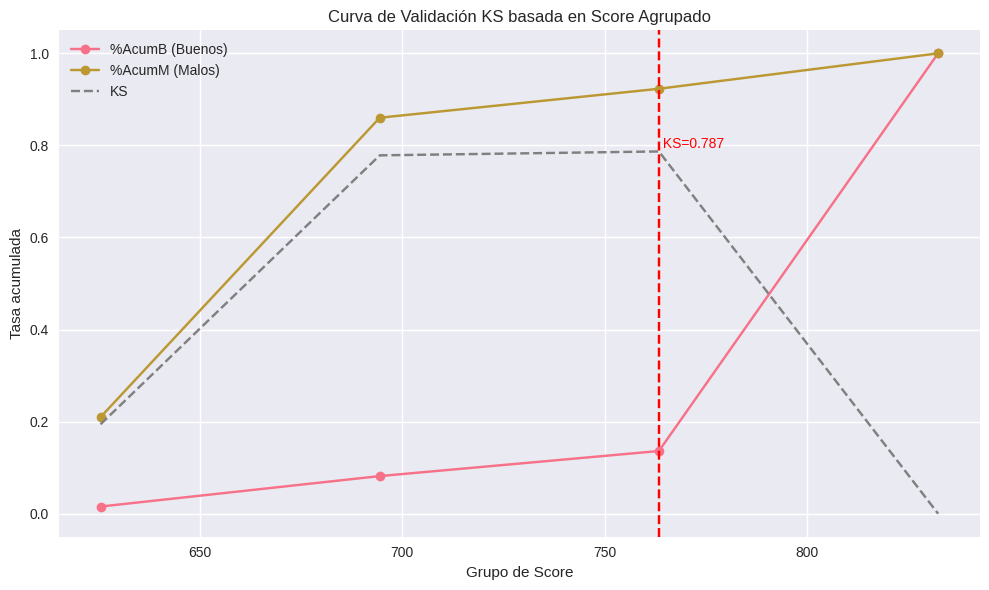

In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# AGRUPACIÓN Y CÁLCULO DE INDICADORES
# -----------------------------

# Agrupar por Score_Agrupado
grouped = df.groupby("Score_Agrupado")["Purchased"].agg(['count', 'sum']).rename(columns={'sum': 'Malos'})
grouped['Buenos'] = grouped['count'] - grouped['Malos']

# Totales
total_malos = grouped['Malos'].sum()
total_buenos = grouped['Buenos'].sum()
total_total = grouped['count'].sum()

# Porcentajes
grouped["%Malos"] = grouped["Malos"] / total_malos
grouped["%Buenos"] = grouped["Buenos"] / total_buenos
grouped["%Total"] = grouped["count"] / total_total

# Acumulados
grouped["%AcumM"] = grouped["%Malos"].cumsum()
grouped["%AcumB"] = grouped["%Buenos"].cumsum()
grouped["%AcumT"] = grouped["%Total"].cumsum()

# Tasa de Malos
grouped["Tasa de Malos"] = grouped["Malos"] / grouped["count"]

# WoE y KS
grouped["WoE"] = np.log(grouped["%Buenos"] / grouped["%Malos"])
grouped["KS"] = abs(grouped["%AcumB"] - grouped["%AcumM"])

# Identificar el punto de KS máximo
ks_value = grouped["KS"].max()
ks_group = grouped["KS"].idxmax()
print(f"KS máximo: {ks_value:.4f} en el grupo: {ks_group}")

# -----------------------------
# GRÁFICA DE CURVA KS
# -----------------------------
plt.figure(figsize=(10, 6))
plt.plot(grouped.index, grouped["%AcumB"], label="%AcumB (Buenos)", marker='o')
plt.plot(grouped.index, grouped["%AcumM"], label="%AcumM (Malos)", marker='o')
plt.plot(grouped.index, grouped["KS"], label="KS", linestyle='--', color='gray')

# Línea vertical en el KS máximo
plt.axvline(x=ks_group, color='red', linestyle='--')
plt.text(ks_group, ks_value, f' KS={ks_value:.3f}', color='red', ha='left', va='bottom')

plt.title("Curva de Validación KS basada en Score Agrupado")
plt.xlabel("Grupo de Score")
plt.ylabel("Tasa acumulada")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


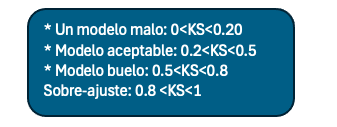

KS máximo ≈ 0.787

Esto indica que en el grupo con score alrededor de 763.41, la diferencia entre las tasas acumuladas de malos y buenos es del 78.7%.

Significa que en ese punto el modelo separa muy bien a quienes sí compran (malos) de quienes no (buenos).

Curva %AcumM (Malos):

Sube rápidamente al inicio. Esto indica que los compradores están mayormente concentrados en los rangos bajos del score, como es deseable.

La curva alcanza casi el 90% en apenas el segundo o tercer grupo.

Curva %AcumB (Buenos):

Es mucho más plana, lo cual es buena señal. Muestra que los buenos (no compradores) están más distribuidos hacia los scores altos.

Curva KS (gris):

La línea punteada que muestra la diferencia absoluta entre las curvas.

El valor pico (rojo) y la línea vertical indican el punto óptimo de corte, donde se maximiza la separación.



Score es 763.41

##GINI

In [138]:
# Asegúrate de que la tabla grouped_ks ya existe y contiene %AcumB y %AcumM

# Copiar la tabla para no modificar la original
gini_df = grouped[["%AcumB", "%AcumM"]].copy()

# Ordenar por Score si no está ordenado
gini_df = gini_df.sort_index()

# Resetear índice para trabajar con filas por posición
gini_df = gini_df.reset_index(drop=True)

# Paso 1: Calcular Delta B y Delta M
gini_df["DeltaB"] = gini_df["%AcumB"].diff().fillna(0)
gini_df["DeltaM"] = gini_df["%AcumM"].diff().fillna(0)

# Paso 2: Calcular A1 como DeltaM * %AcumB anterior
gini_df["%AcumB_lag"] = gini_df["%AcumB"].shift(1).fillna(0)
gini_df["A1"] = gini_df["DeltaM"] * gini_df["%AcumB_lag"]

# Paso 3: Sumar todos los A1s
Ag = gini_df["A1"].sum()

# Paso 4: Gini Index = (Ag - At) / At, con At = 0.5
At = 0.5
gini_index = (Ag - At) / At

# Mostrar resultado
print(f"Área bajo la curva (Ag): {Ag:.6f}")
print(f"Área total (At): {At}")
print(f"Índice de Gini: {gini_index:.6f}")


Área bajo la curva (Ag): 0.025741
Área total (At): 0.5
Índice de Gini: -0.948518


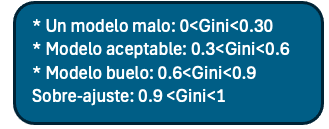

🔹 Tabla paso a paso para índice de Gini:


/tmp/ipython-input-144-1576141739.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby("Score_Agrupado")["Purchased"].agg(['count', 'sum']).rename(columns={'sum': 'Malos'})


,%Buenos,%Malos,%AcumB,%AcumM,DeltaB,DeltaM,%AcumB_lag,A1
0,0.8638,0.0769,0.8638,0.0769,0.0000,0.0000,0.0000,0.0000
1,0.0545,0.0629,0.9183,0.1399,0.0545,0.0629,0.8638,0.0544
2,0.0661,0.6503,0.9844,0.7902,0.0661,0.6503,0.9183,0.5972
3,0.0156,0.2098,1.0000,1.0000,0.0156,0.2098,0.9844,0.2065



 Área bajo la curva (Ag): 0.8581
 Área total (At): 0.5
 Índice de Gini: 0.7162


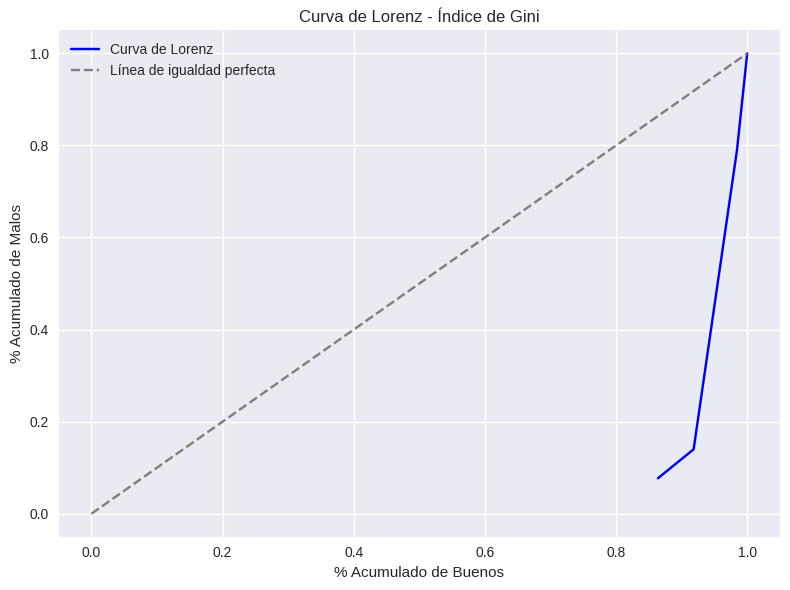

In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Supón que ya tienes un DataFrame df con columnas Score_Agrupado y Purchased

# Paso 1: Agrupar por score
grouped = df.groupby("Score_Agrupado")["Purchased"].agg(['count', 'sum']).rename(columns={'sum': 'Malos'})
grouped['Buenos'] = grouped['count'] - grouped['Malos']

# Totales
total_malos = grouped['Malos'].sum()
total_buenos = grouped['Buenos'].sum()

# Porcentajes
grouped["%Malos"] = grouped["Malos"] / total_malos
grouped["%Buenos"] = grouped["Buenos"] / total_buenos

# Ordenar de mayor a menor (score descendente)
gini_df = grouped[["%Buenos", "%Malos"]].sort_index(ascending=False).reset_index(drop=True)

# Acumulados
gini_df["%AcumB"] = gini_df["%Buenos"].cumsum()
gini_df["%AcumM"] = gini_df["%Malos"].cumsum()

# Delta y A1
gini_df["DeltaB"] = gini_df["%AcumB"].diff().fillna(0)
gini_df["DeltaM"] = gini_df["%AcumM"].diff().fillna(0)
gini_df["%AcumB_lag"] = gini_df["%AcumB"].shift(1).fillna(0)
gini_df["A1"] = gini_df["DeltaM"] * gini_df["%AcumB_lag"]

# Cálculo final del Gini
Ag = gini_df["A1"].sum()
At = 0.5
gini_index = (Ag - At) / At

# Mostrar tabla
print("🔹 Tabla paso a paso para índice de Gini:")
display(gini_df.round(4))

# Mostrar resultado
print(f"\n Área bajo la curva (Ag): {Ag:.4f}")
print(f" Área total (At): {At}")
print(f" Índice de Gini: {gini_index:.4f}")

# Gráfico: Curva de Lorenz
plt.figure(figsize=(8, 6))
plt.plot(gini_df["%AcumB"], gini_df["%AcumM"], label="Curva de Lorenz", color='blue')
plt.plot([0, 1], [0, 1], '--', label="Línea de igualdad perfecta", color='gray')
plt.title("Curva de Lorenz - Índice de Gini")
plt.xlabel("% Acumulado de Buenos")
plt.ylabel("% Acumulado de Malos")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


##IV

In [157]:


# Agrupar por Score_Agrupado
grouped_iv = df.groupby("Score_Agrupado")["Purchased"].agg(['count', 'sum']).rename(columns={'sum': 'Malos'})
grouped_iv['Buenos'] = grouped_iv['count'] - grouped_iv['Malos']

# Totales
total_malos = grouped_iv['Malos'].sum()
total_buenos = grouped_iv['Buenos'].sum()

# Porcentajes
grouped_iv["%Malos"] = grouped_iv["Malos"] / total_malos
grouped_iv["%Buenos"] = grouped_iv["Buenos"] / total_buenos


# 3. Construir la función de distribución acumulada (CDF)
grouped_iv["FDP_Malos"] = grouped_iv["%Malos"]   # función de densidad
grouped_iv["FDP_Buenos"] = grouped_iv["%Buenos"]

grouped_iv["CDF_Malos"] = grouped_iv["FDP_Malos"].cumsum()   # función de distribución acumulada
grouped_iv["CDF_Buenos"] = grouped_iv["FDP_Buenos"].cumsum()

# WoE
grouped_iv["WoE"] = np.log(grouped_iv["%Buenos"] / grouped_iv["%Malos"])

# IV: ( %Buenos - %Malos ) * WoE
grouped_iv["IV"] = (grouped_iv["CDF_Buenos"] - grouped_iv["CDF_Malos"]) * grouped_iv["WoE"]

# IV total
iv_total = grouped_iv["IV"].sum()

# Mostrar tabla y resultado
print("📊 Tabla con cálculo de IV:")
display(grouped_iv[["%Buenos", "%Malos", "WoE", "IV"]].round(4))
print(f"\n✅ Information Value (IV) total: {iv_total:.4f}")


📊 Tabla con cálculo de IV:


/tmp/ipython-input-157-2087107013.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_iv = df.groupby("Score_Agrupado")["Purchased"].agg(['count', 'sum']).rename(columns={'sum': 'Malos'})


,%Buenos,%Malos,WoE,IV
Score_Agrupado,,,,
625.5600,0.0156,0.2098,-2.6011,0.5052
694.4900,0.0661,0.6503,-2.2856,1.7792
763.4100,0.0545,0.0629,-0.1444,0.1136
832.3400,0.8638,0.0769,2.4186,0.0000



✅ Information Value (IV) total: 2.3980


#AUROC

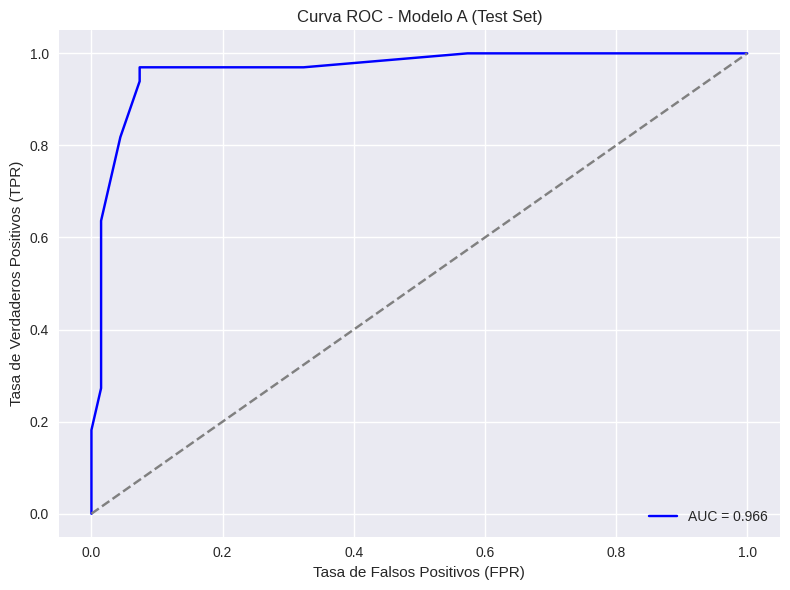

✅ AUC: 0.9657
📊 Índice de Gini: 0.7162


In [158]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# 1. Filtrar el conjunto de prueba (Test)
df_test = df[df["Sample"] == "Test"]

# 2. Variables verdaderas y predichas
y_true = df_test["Purchased"]
y_score = df_test["PD_model_A"]

# 3. Calcular curva ROC
fpr, tpr, thresholds = roc_curve(y_true, y_score)

# 4. Calcular AUC
auc_score = roc_auc_score(y_true, y_score)

# 6. Graficar curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.3f}', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("Curva ROC - Modelo A (Test Set)")
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# 7. Imprimir resultados
print(f"✅ AUC: {auc_score:.4f}")
print(f"📊 Índice de Gini: {gini_index:.4f}")


#comparacion

In [159]:
from sklearn.metrics import classification_report, confusion_matrix

# 1. Seleccionar datos de test
df_test = df[df['Sample'] == 'Test']
X_test = df_test[["Salary_WoE", "Age_WoE"]]
X_test = sm.add_constant(X_test)

# 2. Predecir probabilidades y clases
df_test["Score_model_A"] = np.dot(X_test, result_A.params)
df_test["PD_model_A"] = 1 / (1 + np.exp(-df_test["Score_model_A"]))
df_test["Predicted_class"] = (df_test["PD_model_A"] >= 0.5).astype(int)

# 3. Matriz de confusión
cm = confusion_matrix(df_test["Purchased"], df_test["Predicted_class"])
print("📉 Matriz de Confusión:")
print(cm)

# 4. Reporte detallado
print("\n📊 Reporte de Clasificación:")
print(classification_report(df_test["Purchased"], df_test["Predicted_class"]))


📉 Matriz de Confusión:
[[63  5]
 [ 1 32]]

📊 Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.98      0.93      0.95        68
           1       0.86      0.97      0.91        33

    accuracy                           0.94       101
   macro avg       0.92      0.95      0.93       101
weighted avg       0.95      0.94      0.94       101



/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


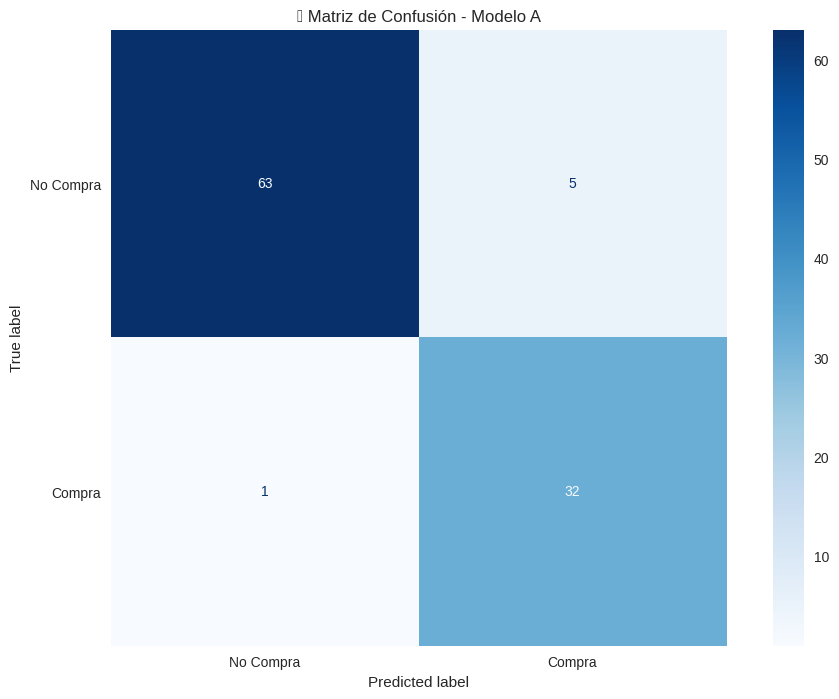

In [165]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 5. Gráfico de la Matriz de Confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Compra", "Compra"])
disp.plot(cmap=plt.cm.Blues)
plt.title("🔍 Matriz de Confusión - Modelo A")
plt.grid(False)
plt.show()


In [160]:
from sklearn.metrics import confusion_matrix

# 1. Matriz de confusión
cm = confusion_matrix(df_test["Purchased"], df_test["Predicted_class"])
TN, FP, FN, TP = cm.ravel()

# 2. Cálculo de métricas
accuracy = (TP + TN) / (TP + TN + FP + FN)
error_rate = 1 - accuracy
tasa_vp = TP / (TP + FN)  # Sensibilidad o Recall
tasa_vn = TN / (TN + FP)  # Especificidad
tasa_fp = FP / (FP + TN)
tasa_fn = FN / (FN + TP)

# 3. Mostrar resultados
print("📊 Matriz de Confusión:")
print(f"Verdaderos Positivos (TP): {TP}")
print(f"Verdaderos Negativos (TN): {TN}")
print(f"Falsos Positivos (FP): {FP}")
print(f"Falsos Negativos (FN): {FN}")

print("\n📈 Métricas:")
print(f"Tasa de Verdaderos Positivos (Sensibilidad): {tasa_vp:.3f}")
print(f"Tasa de Verdaderos Negativos (Especificidad): {tasa_vn:.3f}")
print(f"Tasa de Falsos Positivos: {tasa_fp:.3f}")
print(f"Tasa de Falsos Negativos: {tasa_fn:.3f}")
print(f"Accuracy Ratio: {accuracy:.3f}")
print(f"Error Rate: {error_rate:.3f}")


📊 Matriz de Confusión:
Verdaderos Positivos (TP): 32
Verdaderos Negativos (TN): 63
Falsos Positivos (FP): 5
Falsos Negativos (FN): 1

📈 Métricas:
Tasa de Verdaderos Positivos (Sensibilidad): 0.970
Tasa de Verdaderos Negativos (Especificidad): 0.926
Tasa de Falsos Positivos: 0.074
Tasa de Falsos Negativos: 0.030
Accuracy Ratio: 0.941
Error Rate: 0.059
